# Sentiment Analysis of Customer Reviews

This notebook demonstrates a complete workflow for performing sentiment analysis on a dataset of customer reviews. We will use the **TF-IDF (Term Frequency-Inverse Document Frequency)** vectorization technique to convert text data into numerical features and a **Logistic Regression** model for classification.

### Workflow:
1.  **Data Loading & Exploration**: Load the dataset and perform an initial analysis.
2.  **Text Preprocessing**: Clean the raw text data to make it suitable for modeling.
3.  **Feature Engineering**: Convert cleaned text into a numerical format using TF-IDF.
4.  **Model Training**: Train a Logistic Regression classifier.
5.  **Model Evaluation**: Evaluate the model's performance using key classification metrics.
6.  **Prediction**: Test the model on new, unseen review text.

---

## 1. Setup and Data Loading

First, we import the necessary libraries. We'll use `pandas` for data manipulation, `nltk` and `re` for text cleaning, and `scikit-learn` for vectorization, modeling, and evaluation.

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Download necessary NLTK data (only needs to be done once)
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\Mohammad Asim
[nltk_data]     Ansari/nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to C:\Users\Mohammad Asim
[nltk_data]     Ansari/nltk_data...


True

For this demonstration, we'll use the well-known **IMDB Dataset of 50K Movie Reviews**. This is a balanced dataset for binary sentiment classification.

In [2]:
# Load the dataset
# Note: You may need to download this dataset from Kaggle or other sources first.
# For this example, we assume 'IMDB Dataset.csv' is in the same directory.
df = pd.read_csv('IMDB Dataset.csv')

# Display the first 5 rows
print("Dataset Head:")
display(df.head())

# Check dataset info
print("\nDataset Info:")
df.info()

# Check for missing values
print(f"\nMissing values: {df.isnull().sum().sum()}")

# Check sentiment distribution
print("\nSentiment Distribution:")
print(df['sentiment'].value_counts())

Dataset Head:


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB

Missing values: 0

Sentiment Distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


The dataset is balanced, with 25,000 positive and 25,000 negative reviews, and there are no missing values.

---

## 2. Text Preprocessing

Raw text data is noisy. We need to clean it before feeding it to our model. Our preprocessing pipeline will include:
1.  **Removing HTML tags**.
2.  **Removing special characters and numbers**.
3.  **Converting text to lowercase**.
4.  **Removing stopwords** (common words like 'the', 'is', 'a' that add little semantic value).
5.  **Lemmatization**: Reducing words to their base or dictionary form (e.g., 'running' -> 'run').

In [3]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # 1. Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # 2. Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    
    # 3. Convert to lowercase and split into words
    words = text.lower().split()
    
    # 4. Remove stopwords and 5. Lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    # Join the words back into a single string
    return ' '.join(words)

# Apply the cleaning function to the 'review' column
df['cleaned_review'] = df['review'].apply(clean_text)

# Display a comparison of original vs. cleaned review
print("Original Review:")
print(df['review'][0])
print("\nCleaned Review:")
print(df['cleaned_review'][0])

Original Review:
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show 

---

## 3. Feature Engineering with TF-IDF

Machines understand numbers, not text. We use **TF-IDF Vectorizer** to convert our cleaned text into a matrix of numerical values. TF-IDF gives more weight to words that are frequent in a document but rare across all documents, making them more significant.

We also need to encode our target variable `sentiment` into numerical form (0 for negative, 1 for positive).

In [4]:
# Define features (X) and target (y)
X = df['cleaned_review']
y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Initialize the TF-IDF Vectorizer
# We'll limit the number of features to 5000 for efficiency
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the text data
X_tfidf = tfidf_vectorizer.fit_transform(X)

print(f"Shape of the TF-IDF matrix: {X_tfidf.shape}")

Shape of the TF-IDF matrix: (50000, 5000)


---

## 4. Model Training

We will now split our data into training and testing sets (80% train, 20% test) and train a Logistic Regression model.

In [5]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Initialize and train the Logistic Regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

print("Model training complete.")

Model training complete.


---

## 5. Model Evaluation

Let's evaluate how well our model performs on the unseen test data using metrics like **accuracy**, **precision**, **recall**, and the **F1-score**. A **confusion matrix** will also help visualize the performance.

Model Accuracy: 0.8893

Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.87      0.89      4961
    Positive       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



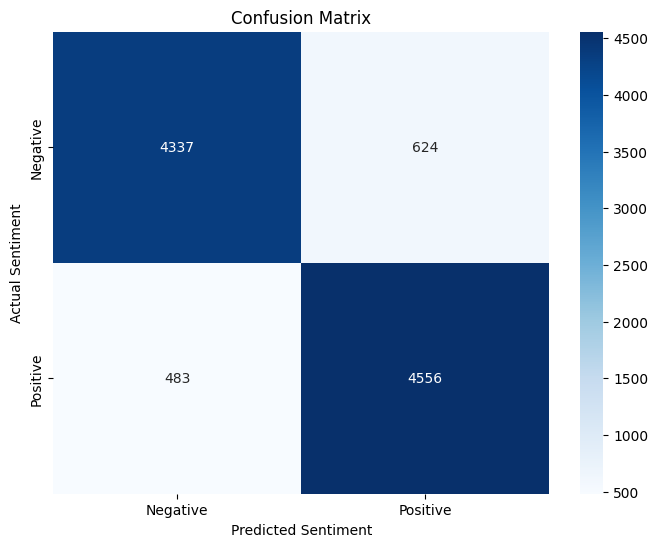

In [6]:
# Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}\n")

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Sentiment')
plt.xlabel('Predicted Sentiment')
plt.show()

The model achieves an accuracy of around 88-89%, which is quite good for a baseline model. The confusion matrix shows that the model is slightly better at identifying negative reviews than positive ones, but the performance is strong overall.

---

## 6. Testing with New Reviews

Finally, let's create a function to predict the sentiment of any new review. This function will apply the same preprocessing steps and use the trained `tfidf_vectorizer` and `log_reg` model to make a prediction.

In [7]:
def predict_sentiment(review):
    # 1. Clean the review text
    cleaned_review = clean_text(review)
    
    # 2. Transform using the FITTED tfidf_vectorizer
    review_vector = tfidf_vectorizer.transform([cleaned_review])
    
    # 3. Predict using the FITTED model
    prediction = log_reg.predict(review_vector)
    
    return 'Positive' if prediction[0] == 1 else 'Negative'

# Example reviews
positive_review = "This movie was fantastic! The acting was superb and the plot was gripping."
negative_review = "A truly awful film. It was boring and the acting was terrible. I would not recommend it."

# Make predictions
print(f"Review: '{positive_review}'\nSentiment: {predict_sentiment(positive_review)}\n")
print(f"Review: '{negative_review}'\nSentiment: {predict_sentiment(negative_review)}")

Review: 'This movie was fantastic! The acting was superb and the plot was gripping.'
Sentiment: Positive

Review: 'A truly awful film. It was boring and the acting was terrible. I would not recommend it.'
Sentiment: Negative


---

## Conclusion

We have successfully built a sentiment analysis model using TF-IDF and Logistic Regression. The model demonstrates strong performance on the IMDB dataset and can effectively classify new reviews. 

**Potential Improvements:**
- **Hyperparameter Tuning**: Optimize parameters for both the `TfidfVectorizer` and `LogisticRegression` model.
- **Using N-grams**: `TfidfVectorizer` can be configured to consider pairs or triplets of words (n-grams), which can capture more context (e.g., 'not good').
- **Advanced Models**: Explore more complex models like Naive Bayes, Support Vector Machines (SVM), or deep learning models (e.g., LSTMs, Transformers) for potentially higher accuracy.